In [43]:
import pandas as pd
from transformers import BertTokenizerFast, BertForTokenClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


 F1 score for id: 19214295
0.8533289459518968

 F1 score for id: 20146086
0.9083886837216716

 F1 score for id: 25139918
0.9795457056702772

 F1 score for id: 25853982
0.9703532999873072

 F1 score for id: 26469535
0.9751447707753567

Classification Report:
                        precision    recall  f1-score   support

        Administration       1.00      1.00      1.00         2
                   Age       1.00      1.00      1.00        25
                  Area       1.00      1.00      1.00         3
  Biological_structure       0.95      0.89      0.92        64
        Clinical_event       0.64      0.88      0.74         8
                 Color       1.00      1.00      1.00         1
           Coreference       1.00      0.43      0.60        14
                  Date       0.96      1.00      0.98        44
  Detailed_description       0.91      0.90      0.91       104
  Diagnostic_procedure       0.94      0.92      0.93        88
      Disease_disorder       0.86   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

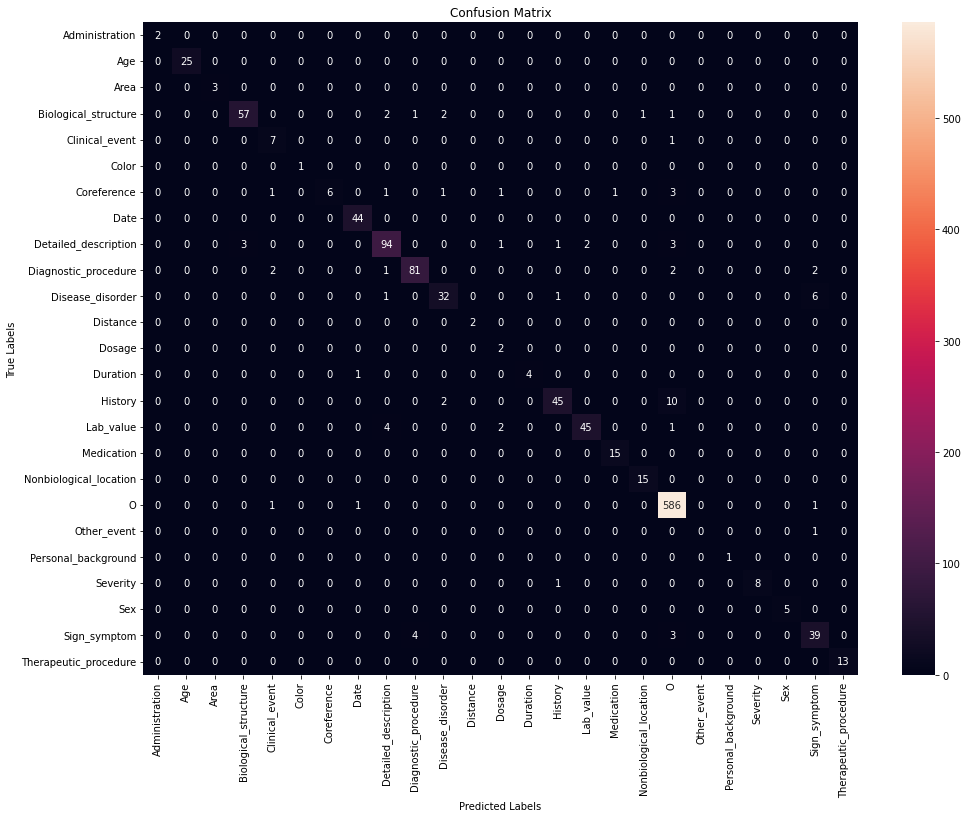

Средний F1-отчет: 1


In [58]:
import pandas as pd
import torch
import joblib
from sklearn.metrics import classification_report, f1_score
from transformers import BertForTokenClassification, BertTokenizerFast

model = BertForTokenClassification.from_pretrained("without_anomalies_PUBMEDBERT_model")
tokenizer = BertTokenizerFast.from_pretrained("without_anomalies_PUBMEDBERT_tokenizer")

label_encoder_path = "version2_label_encoder.joblib"
label_encoder = joblib.load(label_encoder_path)

def process_texts(text_ids, data_path, model, tokenizer, label_encoder):
    data = pd.read_csv(data_path)
    total_f1_scores = []
    all_y_true = []
    all_y_pred = []

    for text_id in text_ids:
        current_data = data[data['Text_ID'] == text_id]
        sentence = " ".join(current_data['Token'].values)
        text_labels = current_data['Label'].values.tolist()

        tokenized_sentence, new_labels = tokenize_and_preserve_labels(sentence, text_labels, tokenizer)
        tokenized_data_df = pd.DataFrame({'Token': tokenized_sentence, 'Label': new_labels})

        word_labels_list = []
        current_word = ""
        current_label = None

        for index, row in tokenized_data_df.iterrows():
            token = row['Token']
            label = row['Label']

            if token.startswith("##"):
                current_word += token[2:]
            else:
                if current_word:
                    word_labels_list.append({'Word': current_word, 'Label': current_label})
                current_word = token
                current_label = label

        if current_word:
            word_labels_list.append({'Word': current_word, 'Label': current_label})

        new_word_labels_df = pd.DataFrame(word_labels_list)

        inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=256)

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        predicted_label_indices = predictions[0].numpy()
        predicted_labels = [label_encoder.inverse_transform([idx])[0] for idx in predicted_label_indices]
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].cpu())
        word_labels = []
        current_word = ""
        current_label = None

        for token, label in zip(tokens, predicted_labels):
            if token.startswith("##"):
                current_word += token[2:]
            else:
                if current_word:
                    word_labels.append((current_word, current_label))
                current_word = token
                current_label = label

        if current_word:
            word_labels.append((current_word, current_label))
            
        word_labels_df = pd.DataFrame(word_labels, columns=['Word', 'Label'])
        filtered_df = word_labels_df[~word_labels_df['Word'].isin(['[PAD]'])]
        filtered_df = filtered_df[~filtered_df['Word'].isin(['[CLS]'])]
        filtered_df = filtered_df[~filtered_df['Word'].isin(['[SEP]'])]

        test_preds_df = pd.DataFrame({'Word': tokens, 'Label': predicted_labels})

        test_labels_df = new_word_labels_df
        test_preds_df = filtered_df

        test_labels_df['Label'] = test_labels_df['Label'].str.replace(r'^(B-|I-)', '', regex=True)
        test_preds_df['Label'] = test_preds_df['Label'].str.replace(r'^(B-|I-)', '', regex=True)
        test_labels_df = test_labels_df[:min(len(test_labels_df), len(test_preds_df))]
        test_preds_df = test_preds_df[:min(len(test_labels_df), len(test_preds_df))]

        assert len(test_labels_df) == len(test_preds_df), "DataFrames have different lengths"

        y_true = test_labels_df['Label'].values
        y_pred = test_preds_df['Label'].values
        
        print(f"\n F1 score for id: {text_id}")
        print(f1_score(y_true, y_pred, average='weighted'))
        
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)
        
    print("\nClassification Report:")
    print(classification_report(all_y_true, all_y_pred))

    report = classification_report(all_y_true, all_y_pred, output_dict=True)
    cm = confusion_matrix(all_y_true, all_y_pred)

    plt.figure(figsize=(16, 12))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(all_y_true), yticklabels=np.unique(all_y_true))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    return 1

def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    tokenized_sentence = []
    labels = []
    for word, label in zip(sentence.split(), text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)
    return tokenized_sentence, labels

text_ids = [19214295, 20146086, 25139918, 25853982, 26469535]
data_path = 'processed_entities_with_sentences_iob_18.csv'
average_f1 = process_texts(text_ids, data_path, model, tokenizer, label_encoder)
print("Средний F1-отчет:", average_f1)


 F1 score for id: 28250406
0.9547889783533539

 F1 score for id: 27130218
0.9592336057686628

 F1 score for id: 19009665
0.9939894815927874

 F1 score for id: 27773410
0.9732356453237403

 F1 score for id: 26457578
0.9555760528514892

Classification Report:
                        precision    recall  f1-score   support

              Activity       1.00      1.00      1.00         4
        Administration       1.00      1.00      1.00         9
                   Age       1.00      1.00      1.00        24
  Biological_structure       0.98      1.00      0.99        47
        Clinical_event       1.00      0.82      0.90        11
           Coreference       1.00      0.33      0.50         6
                  Date       0.92      0.97      0.94        34
  Detailed_description       0.95      0.95      0.95        42
  Diagnostic_procedure       0.98      1.00      0.99        65
      Disease_disorder       1.00      1.00      1.00        36
              Distance       1.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

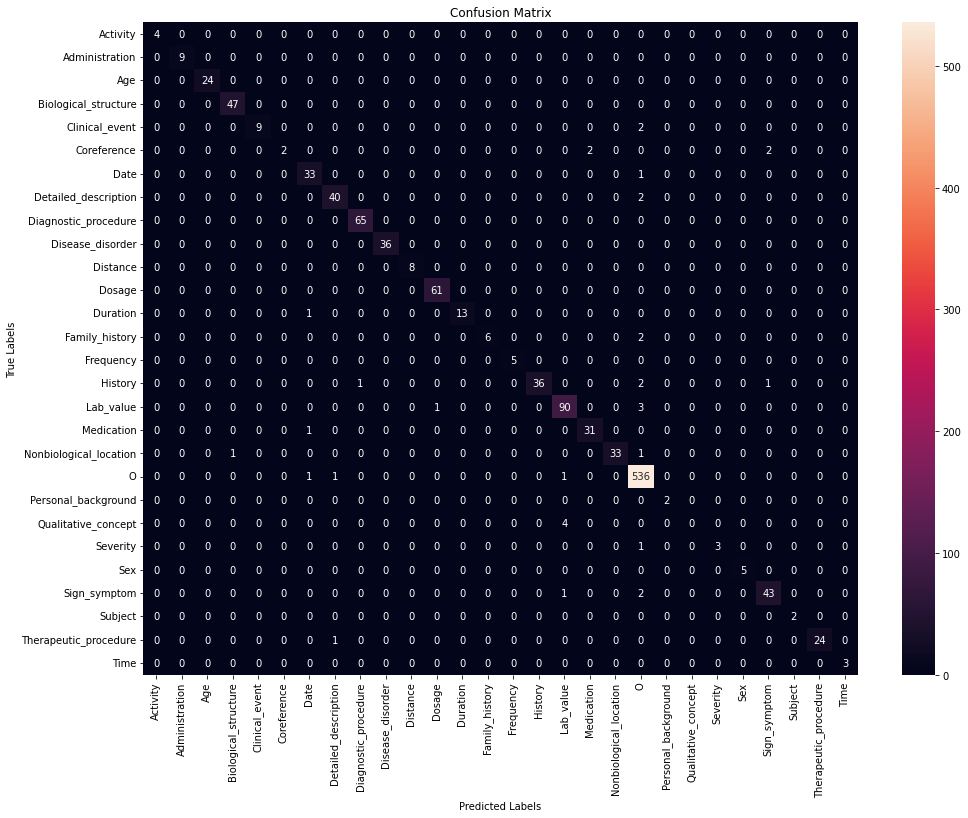

Средний F1-отчет: 1


In [59]:
text_ids = [28250406,27130218, 19009665, 27773410, 26457578]
data_path = 'processed_entities_with_sentences_iob_18.csv'
average_f1 = process_texts(text_ids, data_path, model, tokenizer, label_encoder)
print("Средний F1-отчет:", average_f1)